In [1]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
WA


In [2]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

#from langchain_ollama import OllamaEmbeddings
from langchain_upstage import UpstageEmbeddings, ChatUpstage

from langgraph.graph import StateGraph, START, END, MessagesState

from typing import TypedDict, Literal, List
import random
import re

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# 1단계: 상태 정의 (MessagesState 확장)
class CafeInquiryState(MessagesState):
    inquiry_type: str           # 문의 유형
    retrieved_menus: List[str]  # 검색된 메뉴들

# Vector DB 초기화
#embeddings_model = OllamaEmbeddings(model="bge-m3:latest")
embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

menu_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)


In [5]:

def extract_menu_info(doc: Document) -> dict:
    """문서에서 메뉴 정보 추출"""
    content = doc.page_content
    menu_name = doc.metadata.get('menu_name', 'Unknown')
    
    # 가격 추출
    price_match = re.search(r'₩([\d,]+)', content)
    price = price_match.group(0) if price_match else "가격 정보 없음"
    
    # 설명 추출
    description_match = re.search(r'설명:\s*(.+?)(?:\n|$)', content, re.DOTALL)
    description = description_match.group(1).strip() if description_match else "설명 없음"
    
    return {
        "name": menu_name,
        "price": price,
        "description": description,
        "full_content": content
    }

In [6]:

# 2단계: 노드 함수들 정의

def classify_inquiry(state: CafeInquiryState) -> CafeInquiryState:
    """사용자 문의를 분류하는 단계"""
    print("---문의 유형 분류---")
    
    last_message = state["messages"][-1].content
    
    # 키워드 기반 분류
    if any(keyword in last_message for keyword in ["가격", "얼마", "비용"]):
        inquiry_type = "가격 문의"
    elif any(keyword in last_message for keyword in ["추천", "뭐가 좋", "어떤 게"]):
        inquiry_type = "추천 요청"
    else:
        inquiry_type = "메뉴 문의"
    
    print(f"분류된 문의 유형: {inquiry_type}")
    
    return {"inquiry_type": inquiry_type}


In [7]:

def handle_price_inquiry(state: CafeInquiryState) -> CafeInquiryState:
    """가격 문의에 대한 응답 생성 (Vector DB 검색)"""
    print("---가격 문의 처리 (Vector DB 검색)---")
    
    # 전체 메뉴 검색을 위한 일반적인 쿼리
    docs = menu_db.similarity_search("메뉴 가격", k=5)
    
    response = "저희 카페의 메뉴별 가격은 다음과 같습니다:\n\n"
    
    if docs:
        for doc in docs:
            menu_info = extract_menu_info(doc)
            response += f"• {menu_info['name']}: {menu_info['price']}\n"
    else:
        response += "죄송합니다. 현재 가격 정보를 불러올 수 없습니다."
    
    response += "\n혹시 특정 메뉴에 대해 더 자세한 정보가 필요하시면 언제든 말씀해 주세요!"
    
    # 검색된 메뉴 정보 저장
    retrieved_menus = [extract_menu_info(doc)["name"] for doc in docs] if docs else []
    
    return {
        "messages": [AIMessage(content=response)],
        "retrieved_menus": retrieved_menus
    }

In [11]:

def handle_recommendation(state: CafeInquiryState) -> CafeInquiryState:
    """추천 요청에 대한 응답 생성 (Vector DB 검색)"""
    print("---추천 요청 처리 (Vector DB 검색)---")
    
    # 사용자 메시지에서 키워드 추출하여 더 정확한 검색
    user_message = state["messages"][-1].content
    
    # 추천 관련 키워드로 검색
    docs = menu_db.similarity_search(user_message, k=3)
    
    if not docs:
        # 기본 검색
        docs = menu_db.similarity_search("인기 메뉴", k=3)
    
    response = "고객님께 추천드리는 메뉴는 다음과 같습니다:\n\n"
    
    if docs:
        # 랜덤으로 2개 선택
        selected_docs = random.sample(docs, min(2, len(docs)))
        
        for doc in selected_docs:
            menu_info = extract_menu_info(doc)
            response += f" {menu_info['name']} ({menu_info['price']})\n"
            response += f" {menu_info['description'][:100]}...\n\n"
        
        response += "이 메뉴들은 Vector DB 검색을 통해 고객님의 문의와 가장 관련성 높은 메뉴로 선정되었습니다!"
    else:
        response += "죄송합니다. 현재 추천할 수 있는 메뉴 정보를 불러올 수 없습니다."
    
    # 검색된 메뉴 정보 저장
    retrieved_menus = [extract_menu_info(doc)["name"] for doc in docs] if docs else []
    
    return {
        "messages": [AIMessage(content=response)],
        "retrieved_menus": retrieved_menus
    }


In [12]:

def handle_menu_inquiry(state: CafeInquiryState) -> CafeInquiryState:
    """일반 메뉴 문의에 대한 응답 생성 (Vector DB 검색)"""
    print("---메뉴 문의 처리 (Vector DB 검색)---")
    
    # 사용자 메시지를 바탕으로 검색
    user_message = state["messages"][-1].content
    docs = menu_db.similarity_search(user_message, k=4)
    
    if not docs:
        # 기본 검색
        docs = menu_db.similarity_search("카페 메뉴", k=4)
    
    response = "저희 카페에서는 다음과 같은 메뉴를 제공하고 있습니다:\n\n"
    
    if docs:
        for doc in docs:
            menu_info = extract_menu_info(doc)
            response += f"• {menu_info['name']}: {menu_info['description'][:80]}... ({menu_info['price']})\n\n"
        
        response += "위 메뉴들은 Vector DB 검색을 통해 고객님의 문의와 관련성이 높은 메뉴들입니다."
    else:
        response += "죄송합니다. 현재 메뉴 정보를 불러올 수 없습니다."
    
    response += "\n\n각 메뉴에 대한 자세한 정보나 추천이 필요하시면 언제든 말씀해 주세요!"
    
    # 검색된 메뉴 정보 저장
    retrieved_menus = [extract_menu_info(doc)["name"] for doc in docs] if docs else []
    
    return {
        "messages": [AIMessage(content=response)],
        "retrieved_menus": retrieved_menus
    }


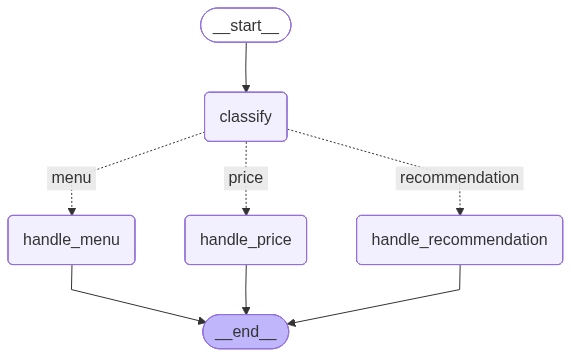

In [ ]:

def decide_response_type(state: CafeInquiryState) -> Literal["price", "recommendation", "menu"]:
    """문의 유형에 따라 다음 실행할 노드를 결정"""
    inquiry_type = state["inquiry_type"]
    if inquiry_type == "가격 문의":
        return "price"
    elif inquiry_type == "추천 요청":
        return "recommendation"
    else:
        return "menu"

# 3단계: 그래프 구성
builder = StateGraph(CafeInquiryState)

builder.add_node("classify", classify_inquiry)
builder.add_node("handle_price", handle_price_inquiry)
builder.add_node("handle_recommendation", handle_recommendation)
builder.add_node("handle_menu", handle_menu_inquiry)

builder.add_edge(START, "classify")
builder.add_conditional_edges(
    "classify",
    decide_response_type,
    {
        "price": "handle_price",
        "recommendation": "handle_recommendation",
        "menu": "handle_menu"
    }
)
builder.add_edge("handle_price", END)
builder.add_edge("handle_recommendation", END)
builder.add_edge("handle_menu", END)

graph = builder.compile()

graph

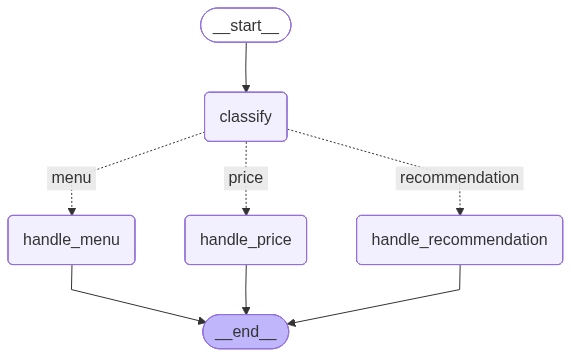

In [15]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:

# 4단계: 실행 및 테스트
def test_inquiry_system_with_vectordb():
    """Vector DB 연동 문의 시스템 테스트 함수"""
    test_messages = [
        "메뉴 가격이 궁금해요",
        "커피 중에서 어떤 메뉴를 추천해 주시나요?",
        "디저트 메뉴가 있나요?"
    ]

    for message in test_messages:
        print(f"\n{'='*60}")
        print(f"고객 문의: {message}")
        print('='*60)
        
        initial_state = {
            "messages": [HumanMessage(content=message)],
            "inquiry_type": "",
            "retrieved_menus": []
        }
        
        result = graph.invoke(initial_state)
        
        print(f"\n카페 응답:\n{result['messages'][-1].content}")
        print(f"\n검색된 메뉴들: {result['retrieved_menus']}")

# 테스트 실행
test_inquiry_system_with_vectordb()


고객 문의: 메뉴 가격이 궁금해요
---문의 유형 분류---
분류된 문의 유형: 가격 문의
---가격 문의 처리 (Vector DB 검색)---

카페 응답:
저희 카페의 메뉴별 가격은 다음과 같습니다:

• 티라미수: ₩7,500
• 바닐라 라떼: ₩6,000
• 프라푸치노: ₩7,000
• 카푸치노: ₩5,000
• 아이스 아메리카노: ₩4,500

혹시 특정 메뉴에 대해 더 자세한 정보가 필요하시면 언제든 말씀해 주세요!

검색된 메뉴들: ['티라미수', '바닐라 라떼', '프라푸치노', '카푸치노', '아이스 아메리카노']

고객 문의: 커피 중에서 어떤 메뉴를 추천해 주시나요?
---문의 유형 분류---
분류된 문의 유형: 추천 요청
---추천 요청 처리 (Vector DB 검색)---

카페 응답:
고객님께 추천드리는 메뉴는 다음과 같습니다:

 바닐라 라떼 (₩6,000)
 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다....

 카푸치노 (₩5,000)
 에스프레소, 스팀 밀크, 우유 거품이 1:1:1 비율로 구성된 이탈리아 전통 커피입니다. 진한 커피 맛과 부드러운 우유 거품의 조화가 일품이며, 계피 파우더를 뿌려 제공합니다....

이 메뉴들은 Vector DB 검색을 통해 고객님의 문의와 가장 관련성 높은 메뉴로 선정되었습니다!

검색된 메뉴들: ['아메리카노', '바닐라 라떼', '카푸치노']

고객 문의: 디저트 메뉴가 있나요?
---문의 유형 분류---
분류된 문의 유형: 메뉴 문의
---메뉴 문의 처리 (Vector DB 검색)---

카페 응답:
저희 카페에서는 다음과 같은 메뉴를 제공하고 있습니다:

• 티라미수: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더... (₩7,500)

• 바닐라 라떼: 카페라떼에 달